In [1]:
from IPython.core.display import HTML
css_file = "./notebook_style.css"
HTML(open(css_file, 'r').read())

# 5. Publishing Scientific Codes

- [Automating installation](#Automating-installation)
    * [Make](#Make)
- [Replicating runtime environments](#Replicating-runtime-environments)
    * [Conda](#Conda)
    * [Containers](#Containers)
    * [Building Docker images](#Building-Docker-images)
    * [Sharing images](#Sharing-images)
- [Distributing code](#Distributing-code)
    * [Licences](#Licences)
    * [DOIs](#DOIs)
- [Presenting results](#Presenting-results)
    * [Presenting data fairly](#Presenting-data-fairly)
    * [Beyond matplotlib](#Beyond-matplotlib)
- [Read more](#Read-more)

In [16]:
from math import floor, sqrt
import numpy
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd

If all goes well, it's likely that at some point you are going to want to publish your code, or at the very least show your code to another person. In this case, it would therefore be great if you could make it as easy as possible for some other person to install and run you code (and potentially even hack away at it themselves). In order to do this, you need to use tools which enable easy installation and replication of your runtime environment.

![Automation](https://intellyx.com/wp-content/uploads/2015/11/automate-all-the-things.jpg)

## Automating installation

For simple python codes, installation may be as easy as downloading the code and running `python filename.py`. However, for more complex codes which are spread over many files, require compilation and/or have multiple dependencies, installation can get a lot trickier. For such cases, it therefore becomes necessary to have some way of automating the installation and build process. This can save a lot of time and makes sure that the project always gets build correctly using the correct file versions. One way of doing this is by using Makefiles.

### Make

![Automation](https://imgs.xkcd.com/comics/automation.png )
##### Automation - [xkcd](https://xkcd.com/1319/)

As projects grow, they often end up spread across many files and directories with complex inter-dependencies. If a change is made to one file, this can have a knock on effect to several other files up the chain of dependencies. Keeping track of all of this and making sure that all files are kept up to date can quickly get complicated and time-consuming.

A solution to this is to automate this using a tool such as `GNU Make`. `Make` can be used to describe the dependencies between files. When a project is rebuilt, it will look to see which files have changed and only rebuild the bits that need rebuilding. This can save a lot of time for large projects where rebuilding everything from scratch can take a while. 

These dependencies between files and instructions for how to build them are described in a `Makefile`. The syntax of a `Makefile` is best illustrated with an example. Let's say that we have a LaTeX document (`report.tex`). This includes a figure (`figures/fig.pdf`) which is produced by running a python script (`py/plot.py`) which plots data (`data/data.h5`) generated by a C++ script (`cpp/main.cpp`). It also contains a BibTeX file (`library.bib`) containing the references. In order to compile this all by hand, we'd need to execute:

```bash
g++ cpp/main.cpp -o main     # compile c++ script
./main                       # run c++ executable to generate data/data.h5
cd py
python plot.py               # run python script to generate figures/fig.pdf
cd ..
pdflatex report              # compile LaTeX file
bibtex report                # run BibTeX to generate references
pdflatex report              # recompile LaTeX file to update references
pdflatex report
```

This is not so bad for our small project, however imagine if you had several plots and that the report was spread across multiple LaTeX files. This would require many different commands to build, and it would be quite easy to miss out one or two or execute them in the wrong order. We can therefore make life simpler for ourselves by automating the build process by using a Makefile.

Makefiles are made up of 'rules' which have the following structure:

```make
target: dependency1 dependency2 ....
    action1
    action2
```

Here, `target` is usually the name of the file we wish to build (though could also be the name of an action such as `clean`), `dependencyX` are the names of the files that the file we want to build depends on (so if they change we'll need to rebuild our target file as well). `actionX` are the bash command(s) that need to be executed in order to build our target file (e.g. compilation instructions). We can also define variables in the Makefile. By convention, these are always in upper case. The variable can then be referred to elsewhere in the code as `${VARNAME}` or `$(VARNAME)`.

Let's write a `Makefile` for our example project to illustrate this better:

#### Makefile
```make
CPP = g++    # Define variable (C++ compiler)

report.pdf: report.tex library.bib figures/fig.pdf
    pdflatex report
    bibtex report
    pdflatex report
    pdflatex report

figures/fig.pdf: py/plot.py data/data.h5
    cd py; python plot.py
    
data/data.h5: cpp/main.cpp
    ${CPP} cpp/main.cpp -o main    # Uses variable defined above for compiler command
    ./main
```

This may on the face of it look more complicated than the sequence of bash commands we needed to build our project before, but once we've written the Makefile, for each rebuild we just need to execute the command 

    make 
    
(assuming the structure of our project does not change). `Make` will then check to see which of the dependencies have changed and rebuild as necessary. For instance, if the LaTeX file has changed but the python and C++ scripts have not, the python and C++ scripts will not be executed to generate new data and a new figure. 

We can also use make to build specific parts of our project by executing it with a target as an argument. For example, if we just wish to generate the data and don't care about updating the figure or report, then you can execute 

    make data/data.h5
    
If you do not give make an argument, it will default to the first target defined in the Makefile - in this case, `report.pdf`.

One thing to note here: if you need to change directories to execute a command, then `cd` must be on the same line as that command (as can be seen here for the build instructions for `figures/fig.py`). This is because each action is executed in its own sub-shell: any changes to the shell environment (such as changing directory) will therefore be restricted to that line only. The shell environment will then revert back to its original state for the next action. 

## Replicating runtime environments

Unfortunately for those of us developing code, no two runtime environments are exactly the same. Every computational setup has its own unique hardware and selection of installed software. However, we wish our code to be as reproducible as possible: ideally, it should be possible to gain exactly the same results, regardless of what system the code is run on. In the interests of open research, it's often the case that we also would like to make our code as accessible as possible. We'd therefore like to support a range of operating systems and computer hardware. 

Whilst it is impossible to replicate exactly the runtime environment in which you developed your code on another machine (no two sets of hardware are identical), it is possible to get a close approximation of the software. 

### Conda
- `conda` is a package and environment management system which allows users to create multiple runtime environments (e.g. containing different versions of libraries) and easily switch between them
- Allows users of your code to install exact version of libraries you use without them having to wreck their own setup

Conda package building tutorials are [here](https://docs.continuum.io/docs_oss/conda/build_tutorials).

### Containers

Containers are a way of producing a lightweight, standalone, executable package of a piece of software. This package (or *container image*) includes everything required to run the software: the code itself, the runtime environment, libraries, settings etc. Software run inside the container will be isolated from the rest of the system. Many containers can be run on the same machine at once, allowing multiple versions of a code or runtime environment to exist at once and run at the same time without conflict. 

Containers share many similarities with virtual machines in that both allow code to be run in isolated runtime environments. However, container images are much more lightweight (typically tens of MBs) as they share the operating system (OS) kernel with other containers; by contrast, virtual machines include a full copy of an operating system, so typically take up tens of GBs. Container images contain exactly what is required by the software and no more; virtual machines contain a of lot of extra material that is likely to already exist on the host machine (e.g. a full operating system).

<div style="float:left;width:45%">
     <img src="images/Container@2x.png" alt="Containers">
     
     <center>Containers</center>
</div>
<div style="float:right;width:45%">
    <img src="images/VM@2x.png" alt="Virtual machines">
    
    <center>Virtual machines</center>
</div>

##### Source: [Docker](https://www.docker.com/what-container)

### Building Docker images

Docker is the most popular service for containers. The docker platform can be installed and run on Linux, Mac OS and Windows. Images created on one OS can be run on any other. 

A quick note on terminology here: an *image* is the executable package of the software, runtime environment, libraries, environment variables and config files. A *container* is a runtime instance of an image. If you're familiar with object oriented programming, this is similar to the distinction between classes and objects. 

Let's build a docker image for the following python application:

#### example_app.py
```python
import socket
import silly
import time

def hello(s):
    print("Hello {}!".format(s))
    print(silly.sentence())

if __name__ == "__main__":
    name = socket.gethostname() # get system hostname
    while(True):
        hello(name)
        time.sleep(2)
```

This code will repeatedly print out `Hello hostname!` (where `hostname` is the system hostname found using the `socket` library), followed by a random sentence generated by the python library `silly`. It will continue printing messages every two seconds until the program is forcibly terminated. 

Now let's create the image. Docker images are described by a `Dockerfile`. This defines the environment inside the container and tells the container how to communicate with your system outside of the container. Here's a `Dockerfile` for our python script:

#### Dockerfile

```C
# Use an official Python runtime as a base image
FROM python:3.5-slim

# Set the working directory to /src
WORKDIR /src

# Copy the current directory contents into the container at /src
ADD . /src

# Install any needed packages specified in requirements.txt
RUN pip install -r requirements.txt

# Run example_app.py when the container launches
CMD ["python", "example_app.py"]
```

This file tells Docker exactly what to do the build the image and run the container. It first installs (a stripped-down version of) python 3.5, then creates and sets the working directory inside the container called `/src` (this is not really necessary for our example, but for larger projects helps keep the code organised). It then copies the code from the current directory into the container's working directory and installs the python libraries listed in `requirements.txt`. Finally, it tells the container what to do when it's launched - run `example_app.py` using python. 

More on `requirements.txt`: this contains a list of the python libraries required by the script. In our case, the only non-standard python library we've used is `silly`, so our requirements file will look like:

#### requirements.txt

```
silly
```

We need to place these three files in the same folder. The Docker image can then be created from within this folder by executing 

    docker build -t example_image .
    
This will build the image in your machine's local Docker image registry, as you should see by running
    
    $ docker images
    
    REPOSITORY          TAG                 IMAGE ID            
    example_image       latest              505747e4b069        
    
We can run our python code within a container by executing 
    
    docker run -t example_image
    
The `-t` flag here tells the docker container to pass along signals to the terminal (so in our case will allow the code in the container to print to the terminal). If our code is going to take a while (such as in our case where the code has a never-ending while loop), instead of cluttering up the terminal with a load of print statements indefinitely, we can instead run the container in the background in *detached mode* by executing

    docker run -d example_image
    
We can see its status by running

    $ docker ps
    
    CONTAINER ID        IMAGE               COMMAND                  CREATED             
    a730c158ffca        example_image       "python example_ap..."   5 seconds ago       

The code in this container can then be stopped by executing `docker stop` followed by the `CONTAINER ID`: 

    docker stop a730c158ffca

### Sharing images

The image that we've created exists on our local machine. We want to share our code with other people so that they can run it on their own machines. To do this, we can upload this image to a service such as [Docker cloud](https://cloud.docker.com/). First, you need to sign into your [cloud.docker.com](https://cloud.docker.com/) account in the terminal:
    
    docker login
        
To publish the image, we first need to 'tag' it. This is a bit like the `git add` command in that it tells Docker to associate the image with a particular remote repository.

    docker tag example_image username/repository_name:tag_name
    
Here, `username` is your docker cloud username and `repository_name` is the name of an exisiting repository in your docker cloud account you'd like to upload the image to. `:tag_name` acts as a sort of version label. If you don't specify it, docker will assume the tag `:latest`. We then upload this tagged image:

    docker push username/repository_name:tag_name
    
Our image is now publicly available for anyone to download and run on their local machine by executing

    docker run username/repository_name:tag_name
    
You can try this now with the example code above (which is also in the `docker_example` folder of this repo) - try running

    docker run harpolea/scientific_programming:latest
    
If you run this multiple times, you will see that when you ask Docker to run an image from a remote repository, it first checks to see whether this image exists on the local machine. If not, it downloads the image first before launching the container. For subsequent runs, Docker can go straight ahead and launch a container as the image already exists on the local machine.

You can link your Docker cloud account to your GitHub account and create repositories linked to existing GitHub repositories. Provided Docker can find a `Dockerfile`, it will then rebuild the repository's image whenever changes are pushed to the GitHub repo, therefore automatically keeping it up to date with the latest version of your code. You can read more about linking your GitHub account [here](https://docs.docker.com/docker-cloud/builds/link-source/) and automating builds [here](https://docs.docker.com/docker-cloud/builds/automated-build/).

## Distributing code

If you've written a bit of scientific code that does something cool, you probably will want to share it with someone else. This can be as simple as sharing a link to your github repo via email / twitter / your blog, however there are also various package indexes you can upload your code to, making it easier for others to find and download. 

For python, packages can be uploaded to the [Python Package Index](https://pypi.python.org/pypi), PyPI. This will allow anyone to download and install your code by running `pip install package_name`. For python and general code projects, conda packages can be uploaded to [anaconda.org](Anaconda.org), allowing anyone to download and install the code (and conda environment if specified) by running `conda install -c CHANNEL package_name`, where `CHANNEL` is your [anaconda.org](Anaconda.org) username. As described above, you can upload a Docker image of your project to the Docker cloud.

### Licences

Before you share your code, you should make sure that it has the correct software licence. The licence states who owns the software, who is allowed to use it and what rights the users and owners have. The licence typically takes the form of a text file called `LICENSE` in the project's root directory. [Choose a license](http://choosealicense.com/) is a good place to start for open source projects.

### DOIs

Unfortunately, the internet is a pretty transient place. Websites are often rearranged, making it hard to provide links that will still be valid in a few months, let alone a few years. If you intend to reference your code in a paper, it is therefore a good idea to give your code a digital object indentifier (DOI). This is a unique alphanumeric string by which content can be identified and which will provide a persistent link to its location on the internet. Someone reading your paper a few years later will therefore be able to look up the exact version of your code which you used to generate the results in the paper, and download and run the code themselves to replicate the results.

Free DOIs for GitHub repositories can be obtained using [zenodo](https://zenodo.org/). Once a repository is registed, a new DOI will automatically be generated every time you [create a new release](https://help.github.com/articles/creating-releases) of your code on GitHub.

## Presenting results


If you have some results or data that you think is interesting, then at some point you're going to want to present them to others to try and convince them that they are interesting too. The best way to do this is typically through generating figures - graphical representations of data allow the reader to better see patterns and are (hopefully) much easier to understand than a bunch of numbers. To maximise the impact of your figures, you should make sure that they are
- easy to understand - the point of figures is to present data in a way that is easier to understand than simply looking at the raw data. If your figure is hard to read, readers will simply skip over it.
- informative - the way data is presented can powerfully influence how your reader will interpret the results
- attractive - if someone is just skimming a paper, you want to make sure that your figures catch their eye!

It's often very tempting to just use the default settings to produce figures, but in almost all cases figures can be radically improved by a few minor tweaks (e.g. adding a legend, increasing font size of axis labels, changing the default colours). In the following sections, we shall look at a few things to do to improve the readability and impact of figures. 

![Defaults vs tweaked](images/journal.pcbi.1003833.g004.png)
These two plots of the sine and cosine functions demonstrate the importance of going beyond the defaults - the one of the left uses the matplotlib default settings, the one of the right has been tweaked so that it is much more informative. [source](http://dx.doi.org/10.1371/journal.pcbi.1003833.g004)

### Presenting data fairly

The way that data is presented has a huge impact on how it is interpreted by the reader. Check out [viz.wtf](http://viz.wtf/) for numerous examples of data presented in misleading ways. Let's use some [data](https://opendata.socrata.com/Business/All-Starbucks-Locations-in-the-World/xy4y-c4mk) about Starbucks per country. The following plots compare the number of Starbucks per country (for those countries containing >= 200 stores). In the first plot, the area of the bubbles is proportional to the number of stores in the country; in the second, the number of stores is instead proportional to the radius. 

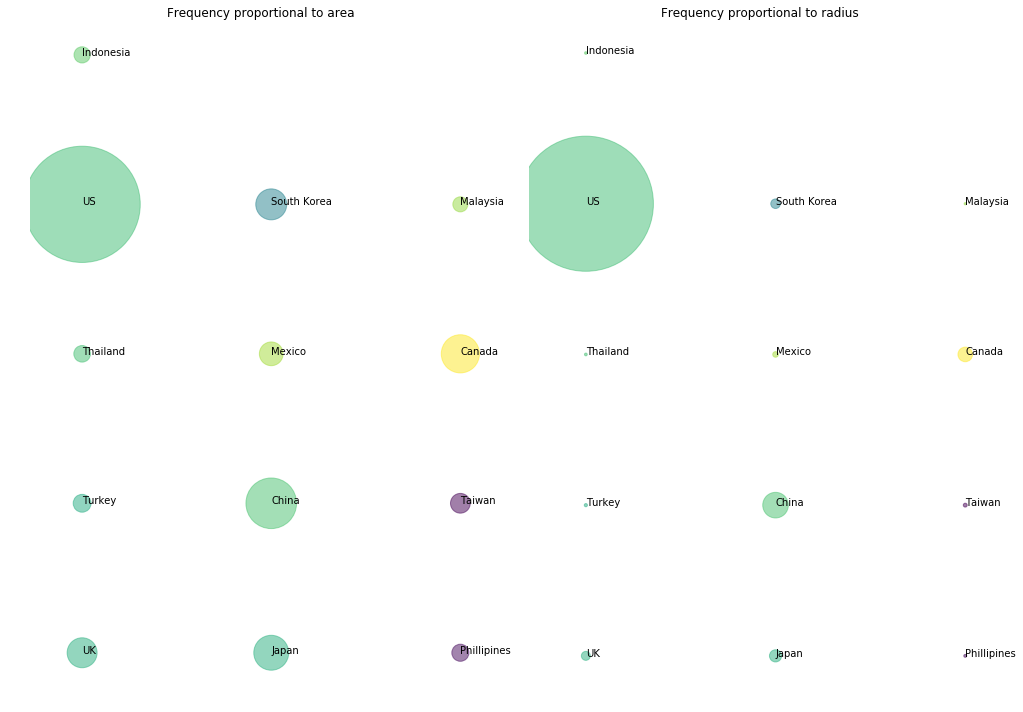

In [3]:
df = pd.read_csv('images/starbucks.csv', sep=',')
dat = df.values

countries = {}

for c in dat:
    countries.setdefault(c[0], 0)
    countries[c[0]] += 1

names = []; freq = []
name_dict = {'CA': 'Canada', 'GB': 'UK', 'PH': 'Phillipines', 'ID': 'Indonesia', 'KR': 'South Korea', 'TW': 'Taiwan', 'CN': 'China', 'MX': 'Mexico', 'TR': 'Turkey', 'US': 'US', 'JP': 'Japan', 'MY': 'Malaysia', 'TH': 'Thailand'}

for key, value in countries.items():
    if value >= 200:
        names.append(name_dict[key])
        freq.append(value)
    
# switch to lists for plotting
#names = list(countries.keys())
#freq = list(countries.values())

# generate positions of points 
xs = [i % floor(sqrt(len(names))) for i in range(len(names))] 
ys =  [int(i / floor(sqrt(len(names)))) for i in range(len(names))]
colours = numpy.random.rand(len(names))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,10))
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
axes[0].scatter(xs, ys, s=freq, c=colours, alpha=0.5)
for i, name in enumerate(names):
    axes[0].annotate(name, (xs[i], ys[i]))
axes[0].axis('off')
axes[0].set_title('Frequency proportional to area')
axes[1].scatter(xs, ys, s=numpy.array(freq)**2*1e-4, c=colours, alpha=0.5)
for i, name in enumerate(names):
    axes[1].annotate(name, (xs[i], ys[i]))
axes[1].axis('off')
axes[1].set_title('Frequency proportional to radius')
plt.tight_layout()
plt.show()

In the second plot, the number of stores in the US appears to completely dwarf the number of stores in all other countries, however if we look at the data, we see that there are only around 5 times as many stores there than in China, and 9 times as many stores as in Canada. The way the data has been plotted has therefore distorted our interpretation.

In [4]:
print('Number of stores in the US / China: {}'.format(countries['US']/ countries['CN']))
print('Number of stores in the US / Canada: {}'.format(countries['US']/ countries['CA']))

Number of stores in the US / China: 5.275283092541976
Number of stores in the US / Canada: 9.278846153846153


### Beyond matplotlib

`Matplotlib` is extremely powerful, but it often takes a lot of work to make good plots. There are many packages out there that extend `matplotlib`'s capabilities, allowing you to make better looking plots with less work. Interactive plots can be a much more powerful way to present data than traditional static plots - some journals are moving to allow these sorts of plots in (the online versions of) papers, and this is likely only to increase in the future. Libraries such as `bokeh` and `plotly` allow easy generation of such plots. 

In this section, we shall look at a few different python visualisation libraries.

To see how these different libraries offer improvements over `matplotlib`, we need something to compare against. Let's first create an example plot using `matplotlib`'s default settings of a few offset sine waves. 

In [5]:
n_curves = 6
xs = numpy.linspace(-2*numpy.pi, 2*numpy.pi, 200)
ys = [(i+1) / n_curves * numpy.sin(xs + 0.5 * i * 2 * numpy.pi / n_curves) for i in range(n_curves)]

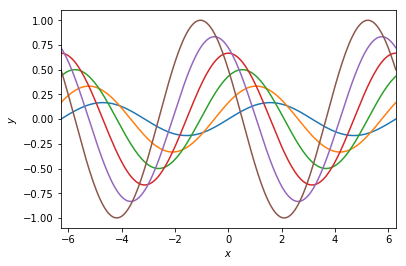

In [6]:
mpl_figure = plt.figure()
for i in range(n_curves):
    plt.plot(xs, ys[i])
plt.xlim(xs[0], xs[-1])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

We can add some interactivity to this plot by enabling interactive mode using some ipython magics: `%matplotlib notebook`. This allows us to zoom in and pan, and displays the cursor location when you hover over it. If we wanted, we could add extra interactivity to our plot using the `matplotlib` [event handler API](http://pbpython.com/effective-matplotlib.html), e.g. add events which change the plot on mouse clicks or keyboard presses. [This tutorial](http://pbpython.com/effective-matplotlib.html) gives a nice example of how to build an interactive `matplotlib` plot to view 2D slices of 3D data. 

To see the interactive environment in action, try running the cell below and then replot the plot in the cell above. Note that the interactive mode only supports one active interactive plot at a time. To plot the next plot, you need to first stop the plot's interaction by clicking on the standby button in the top right corner. 

In [7]:
% matplotlib notebook

#### Seaborn

[`Seaborn`](https://seaborn.pydata.org/) is a python visualisation library based on matplotlib. It works as an extension to matplotlib - when you import it, seaborn will apply its default parameters to the matplotlib style dictionary. This will change the look of all plots, including those created using matplotlib functions directly. With minimal tweaks, we can generate a plot that is already an improvement on the previous matplotlib plot (larger default size, muted default colours are more screen-friendly, lines are thicker, removed top and right axes using a single command).

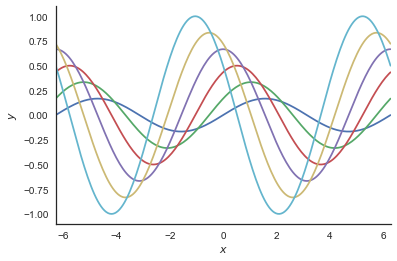

In [17]:
import seaborn as sns 

sns.set_style("white") # use white style to match matplotlib defaults
for i in range(n_curves):
    plt.plot(xs, ys[i])
plt.xlim(xs[0], xs[-1])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
sns.despine() # remove top and right axes
plt.show()

#### Bokeh

[`Bokeh`](http://bokeh.pydata.org) is a python interactive visualisation library. It provides a powerful interface for producing interactive plots. Interactive plots are a great way of presenting large, complex datasets as they allow the reader to zoom in on detailed areas and interact with the plot via tooltips, interactive legends to filter data and other widgets. Unlike `seaborn`, `bokeh` is an entirely separate library to `matplotlib`, so the syntax is a bit different (as can be seen in the following example).

In [9]:
import bokeh.plotting as bkh
from bokeh.plotting import reset_output
from bokeh.io import output_notebook, show, push_notebook
from bokeh.palettes import brewer
reset_output()
output_notebook()

Loading BokehJS ...

In [10]:
fig = bkh.figure()
colours = brewer["Spectral"][n_curves]
for i in range(n_curves):
    fig.line(xs, ys[i], line_color=colours[i], line_width=2)
fig.xaxis.axis_label = 'x'
fig.yaxis.axis_label = 'y'
show(fig)

For simple static plots, using a tool like `bokeh` is probably overkill: its real strength becomes apparent when you start incorporating some of its more advanced interactive features. Below is a more complex example to demonstrate some of the features of `bokeh`'s interactive plots. The plots show  the evolution of global temperatures between 1880-2005, comparing observed temperatures against NASA simulations of the effects of natural and human influences on climate. With just a few lines of code, we are able to produce an interactive plot with multiple panes and tooltips to help the reader investigate specific data points. The data and analysis is based on [this notebook](https://github.com/BuzzFeedNews/2017-01-causes-of-warming).

In [11]:
observed = pd.read_csv("https://data.giss.nasa.gov/gistemp/graphs/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.csv", 
                       skiprows=2, index_col=0)
simulations = pd.read_csv("https://www.bloomberg.com/graphics/2015-whats-warming-the-world/data/forcings.csv", 
                          index_col=0)
simulations = simulations.loc[1880:]
baseline = simulations.loc[1951:1981].mean()
simulations -= baseline
simulations.rename(columns={'Anthropogenic tropospheric aerosol':'Aerosol'},  inplace=True)

In [12]:
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import HoverTool

f1 = bkh.figure()
f1.add_tools(HoverTool(tooltips=[("Year", "$x{0}"),("Temp change", "$y"),]))
f2 = bkh.figure()
f2.add_tools(HoverTool(tooltips=[("Year", "$x{0}"),("Temp change", "$y"),]))
colours = brewer["Spectral"][8]

f1.line(simulations.index.values, 0, line_color='black', line_width=2)
f1.line(observed.index.values,observed.iloc[:,0].values, line_color=colours[0], 
              line_width=2, legend='Observed')
for i in range(1,3):
    f1.line(simulations.index.values, simulations.iloc[:,i].values, line_color=colours[i*2+3], 
                line_width=2, legend=simulations.iloc[:,i].name)
f1.legend.location = "top_left"
tab1 = Panel(child=f1, title="Human vs natural")

f2.line(simulations.index.values, 0, line_color='black', line_width=2)
f2.line(observed.index.values,observed.iloc[:,0].values, line_color=colours[0], 
              line_width=2, legend='Observed')
for i in range(3,10):
    f2.line(simulations.index.values, simulations.iloc[:,i].values, line_color=colours[i-2], 
                line_width=2, legend=simulations.iloc[:,i].name)
f2.legend.location = "top_left"
tab2 = Panel(child=f2, title="Detailed")

tabs = Tabs(tabs=[tab1, tab2])
show(tabs)

#### plotly

`plotly` is another tool for creating interactive plots. Like `bokeh`, it is a seperate library to `matplotlib` rather than an extension, with its own syntax. However, it can also work in conjuction with `matplotlib`, allowing you to easily convert plots into interactive `plotly` objects. Let's recreate our previous sine wave plot using `plotly` functions:

In [13]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go

traces = []

for i in range(n_curves):
    t = go.Scatter(x=xs, y=ys[i], mode='lines', name='line {}'.format(i))
    traces.append(t)

layout = dict(xaxis=dict(title = 'x'), yaxis=dict(title = 'y'))
fig = dict(data=traces, layout=layout)

plotly.offline.iplot(fig)

Now compare this to a plot generated by converting our previous `matplotlib` figure:

In [14]:
import plotly.tools as tls

plotly_fig = tls.mpl_to_plotly(mpl_figure)
plotly.offline.iplot(plotly_fig)

Let's try and recreate the more complex `bokeh` plot above. Note how individual curves can be hidden / selected by clicking on their names in the legend.

In [15]:
fig = tls.make_subplots(rows=1, cols=2, subplot_titles=('Human vs natural', 'Detailed'))

t = go.Scatter(x=simulations.index.values, y=0*simulations.index.values, mode='lines', name='baseline')
fig.append_trace(t, 1, 1)
fig.append_trace(t, 1, 2)

t = go.Scatter(x=observed.index.values, y=observed.iloc[:,0].values, mode='lines', name='observed')
fig.append_trace(t, 1, 1)
fig.append_trace(t, 1, 2)

for i in range(1,10):
    t = go.Scatter(x=simulations.index.values, y=simulations.iloc[:,i].values, mode='lines', 
                   name=simulations.iloc[:,i].name)
    if i < 3:
        fig.append_trace(t, 1, 1)
    else:
        fig.append_trace(t, 1, 2)

fig['layout']['xaxis1'].update(title='Year')
fig['layout']['xaxis2'].update(title='Year')

fig['layout']['yaxis1'].update(title='Temperature change')
fig['layout']['yaxis2'].update(title='Temperature change')
    
plotly.offline.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



## Read more
### Make
- [A minimal make tutorial](http://kbroman.org/minimal_make/)
- A more detailed [make tutorial](http://opensourceforu.com/2012/06/gnu-make-in-detail-for-beginners/)
- The full [make manual](https://www.gnu.org/software/make/manual/make.html)

### Containers
- [What is a container?](https://www.docker.com/what-container)
- [Getting started with Docker](https://docs.docker.com/get-started/)
- [Automated Docker image builds](https://docs.docker.com/docker-cloud/builds/automated-build/)

### Distributing code
- [Zenodo](https://zenodo.org/) for generating DOIs for projects

### Presenting results
- [Effectively using Matplotlib](http://pbpython.com/effective-matplotlib.html) shows how to take advantage of `matplotlib`'s object oriented interface to make better plots
- See [this article](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003833) for some key points to consider when making figures
- Check out the [`bokeh` gallery](http://bokeh.pydata.org/en/latest/docs/gallery.html) for lots of cool examples demonstrating `bokeh's` powerful interactive plotting tools
- [Plotly for python](https://plot.ly/python/) contains lots of examples, including a whole load of scientific plots